# Defective PV Module Cells Transfer Learning

En ocasiones, no resulta del todo eficiente entrenar un modelo convolucional desde cero pues es posible que para alcanzar una mejor abstracción en la extracción de features dentro del modelo se requieran una mayor cantidad de datos e incluso un mayor tiempo de entrenamiento, lo que no siempre será factible. Una forma de baipasear este problema es reutilizar las arquitecturas y parámetros de modelos previamente entrenados para la resolución de otros problemas similares al de interés.

En este sentido, el transfer learning consiste en adaptar modelos previamente desarrollados para facilitar el aprendizaje del nuevo modelo sobre el problema de interés, del mismo modo en que alguien que sabe guitarra podría aprender a tocar bajo más rapidamente que alguien sin ninguna experiencia musical.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_04/bin/banner.png" width="950">


Convenientemente, `keras` provee de una serie de modelos pre-entrenados de alto nivel mediante su módulo `applications`, con funcionalidades tanto para cargar las arquitecturas y parámetros, como para adaptarlo a las estructuras y datos del problema en estudio. Así, en este workshop volveremos a usar el dataset de electroluminiscencias de celdas solares fotovoltaicas para el desarrollo de un modelo convolucional clasificación mediante transfer learning.

- https://keras.io/api/applications/

## ELPV Dataset

Para recordar el contenido del dataset que utilizaremos, este cuenta con `2624` imágenes de `300x300 px`, en escala de grises, con celdas fotovoltacias bajo distintos niveles de degradación. De este modo, cada imagen o muestra cuenta con una etiqueta que indica la probabilidad, estimada bajo la evaluación de un experto, de que la muestra presente un estado defectuoso.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_03/bin/banner.png" width="950">

El dataset se encuentra publicado en un repositorio github:
- https://github.com/zae-bayern/elpv-dataset

In [ ]:
# cargar GitHub https://github.com/zae-bayern/elpv-dataset.git
!git clone https://github.com/zae-bayern/elpv-dataset.git
%cd /content/elpv-dataset/utils

from elpv_reader import load_dataset

# importar colección de imágenes y etiquetas
images, proba, types = load_dataset()

Cloning into 'elpv-dataset'...
remote: Enumerating objects: 2686, done.
remote: Total 2686 (delta 0), reused 0 (delta 0), pack-reused 2686
Receiving objects: 100% (2686/2686), 90.79 MiB | 49.01 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/elpv-dataset/utils


También aprovecharemos de cargar el GitHub del curso deeplearningfallas para disponer de algunas utilidades que nos serán de utilidad más adelante.

In [ ]:
# cargar GitHub https://github.com/cherrerab/deeplearningfallas.git
%cd /content/
!git clone https://github.com/cherrerab/deeplearningfallas.git
%cd /content/deeplearningfallas

/content
Cloning into 'deeplearningfallas'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 321 (delta 26), reused 0 (delta 0), pack-reused 249
Receiving objects: 100% (321/321), 36.91 MiB | 22.22 MiB/s, done.
Resolving deltas: 100% (114/114), done.
/content/deeplearningfallas


---
# Training Data

Vale la pena recordar que en este dataset las probabilidades en `proba` no siguen una distribución continua entre `[0.0, 1.0]`. En cambio, este valor depende de la incertidumbre del experto al realizar el diagnóstico de daño, como se muestra en la tabla a continuación.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_03/bin/data_table.png" height="140">

Así, de la misma manera que en el workshop anterior, agruparemos estas cuatro clases en solamente dos: `functional cells` y `defective cells`. Por un lado, la clase `functional cells` estará compuesto únicamente de las muestras con probabilidad `0.0`, mientras que `defective cells` agrupará el resto de las clases en el dataset. De este modo, aparte de aislar completamente las celdas que con certeza no presentan ninguna clase de defectos, dado que la función `softmax` indica la probabilidad de pertenencia a cada una de las clases, podemos utilizar esta propiedad para comparar las predicciones del modelo con las etiquetas iniciales.

Por otro lado, volveremos a utilizar la función `train_test_split` de `sklearn` para dividir los datos en los sets de entrenamiento `(X_train, Y_train)` y testing `(X_test, Y_test)`. Esta función dividirá de manera aleatoria los datasets ingresados en dos subonjuntos o `subsets` de entrenamiento y testing.

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [12]:
import numpy as np
from keras.utils import to_categorical

# transformar lista de probabilidades
labels = np.array( proba < 0.1, dtype=int) 

# transformar a one hot encoding
Y = to_categorical( labels )

from sklearn.model_selection import train_test_split

# ---
# transformar images a shape (samples, height, width, channel)
# compatible para el entrenamiento.
# adicionalmente transformaremos las imágenes a RGB para compatibilizar
# nuestros datos con el modelos que usaremos para el transfer learning.
# una manera rápida de hacer este proceso es mediante np.stack
X = np.reshape( images, (-1, 300, 300) )
X = np.stack( [X, X, X], axis=3 )

# realizar data splitting
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=0 )

# print sample distribution
print( 'train split: {:d} samples'.format(X_train.shape[0]) )
print( '\ntesting split: {:d} samples'.format(X_test.shape[0]) )

train split: 2099 samples

testing split: 525 samples


---
## Transfer Learning

El VGG-16 es un modelo convolucional propuesto por K. Simonyan y A. Zisserman, del Visual Graphics Group (VGG) de la Universidad de Oxford y fue descrito en el paper "Very Deep Convolutional Networks for Large-Scale Image Recognition (2014)". Este modelo fue desarrollado sobre el ImageNet Large Scale Visual Recognition Challenge, también referido simplemente como ImageNet, el cual consiste en un dataset de más de 14 millones de imágenes para la clasificación de alrededor de 1000 de clases diferentes de objetos. En 2014, la red VGG-16 fue propuesta al challenge alcanzando un 92.7% de accuracy.

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width="600">

Para este caso particular, utilizaremos la VGG-16 como un extractor de features, donde usaremos el output de la última capa convolucional del modelo como input para nuestro modelo de clasificación de daño. Recordemos que en general, las capas convolucionales cercanas a la entrada de la red aprenden a extraer low-level features de la imagen, mientras que aquellas más cercanas a la salida suelen aprender features con una mayor abstracción y complejidad para la interpretación final de la imagen de entrada.

De este modo, cargaremos el modelo VGG-16 contenido en `keras.applications` y acoplaremos la sección convolucional del modelo con una serie de capas `Dense` para la clasificación binaria del problema.

- https://keras.io/api/applications/vgg/

In [ ]:
from keras.applications import VGG16
from keras.models import Model

# ---
# inicializar el modelo VGG-16
# el parámetro include_top permite especificar si se cargarán las capas
# fully connected del modelo o bien, únicamente la sección convolucional.
# el parámetro weights permite definir si se cargarán los pesos pre-entrenados
# del modelo o si estos se inicializarán de manera aleatoria.
# https://keras.io/api/applications/vgg/

input_shape = (300, 300, 3)
VGG = VGG16(include_top=False, weights='imagenet', input_shape=input_shape )

# ---
# configurar modelo VGG-16 para la extracción de features

# extraer input del modelo VGG-16
input = VGG.input

# extraer output de la última capa del modelo VGG-16
VGG_output = VGG.layers[-1].output

# generar sección VGG-16 y detener el entrenamiento de sus parámetros
VGG_model = Model(input, VGG_output)

# las keras.layers y los keras.models poseen el atributo trainable (bool).
# este permite "congelar" los parámetros de la capa o modelo, de modo que
# los pesos no serán ajustados durante el entrenamiento.
for layer in VGG_model.layers:
  layer.trainable = False

# print VGG_model.summary()
VGG_model.summary()

58892288/58889256 [==============================] - 0s 0us/step


Así hemos configurado la primera sección convolucional de nuestro modelo de clasificación, el cual extraerá los `feature map` aprendidos para el reconocimiento de objetos dentro del problema de ImageNet.

Resulta interesante observar el resultado preliminar de estos `feature maps` al ingresar una imagen del ELPV Dataset. Para esto ultilizaremos la función `plot_img_samples` que usamos en el workshop anterior y que se encuentra en el módulo `utils` del github del curso.

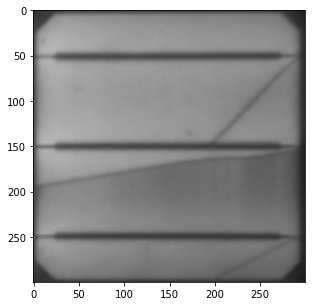

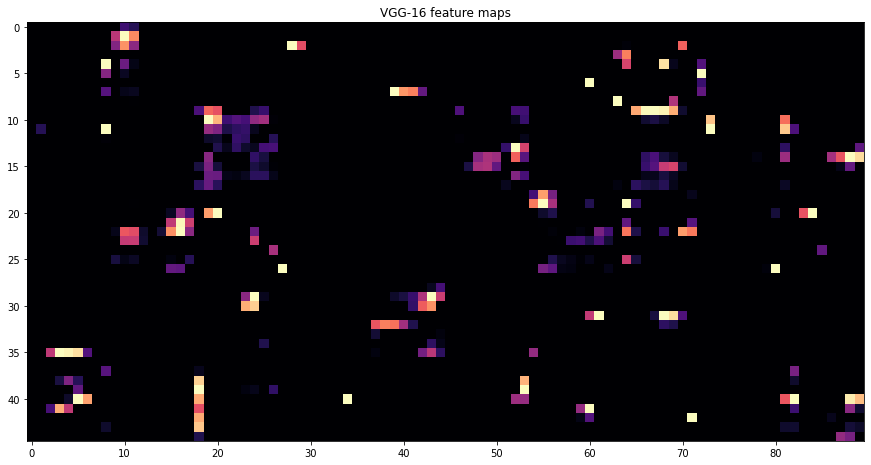

In [ ]:
from utils import plot_img_samples
import matplotlib.pyplot as plt

# obtener imagen de muestra del ELPV dataset
# en este caso utilizaremos el dato número 288
img = X_train[288, :, :, :]

# visualizar imagen de muestra
plt.figure( figsize=(5, 5) )
plt.imshow(img)

# ---
# extraer VGG-16 feature maps
x = np.reshape(img, (1, 300, 300, 3))
VGG16_fmap = VGG_model.predict(x)

# reordenar feature maps a (feature_maps, height, width)
fmaps = np.zeros( (512, 9, 9) )
for i in range( 512 ):
  fmap = VGG16_fmap[:, :, :, i]
  fmaps[i, :, :] = np.reshape( fmap, (1, 9, 9) )

# visulizar fmaps mediante plot_img_samples
plot_img_samples(fmaps, range(50), grid=(5, 10),
                 figsize=(15,15),title='VGG-16 feature maps')

Ahora, como se mencionó anteriormente, finalizaremos nuestro modelo de clasificación agregando una serie de capas `Dense`, para terminar de procesar la información, hasta una última capa de salida `softmax`.

In [19]:
from keras.models import Model

from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D

# ---
# ahora debemos ir agregando nuestras capas Dense para procesar la
# información hasta la capa de salida.
# https://keras.io/api/layers/core_layers/dense/

model = Flatten()(VGG_output)
model = Dropout(rate=0.25)(model)
model = Dense(units=128, activation='relu')(model)
model = Dense(units=128, activation='relu')(model)

model = Dropout(rate=0.2)(model)
model = Dense(units=64, activation='relu')(model)
model = Dense(units=32, activation='relu')(model)

# ---
# por último debemos configurar nuestra capa de salida
# dado que el modelo consiste en uno de clasificación emplearemos
# la función softmax, donde cada nodo indicará la probabilidad de que
# los datos correspondan a una de las etiquetas o estados de salud.
labels_num = 2
model_output = Dense(units=labels_num, activation='softmax')(model)

# ---
# generar modelo de clasificación
ELPV_Model = Model(input, model_output)

# print ELPV_Model.summary()
ELPV_Model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)      

## Compile Model

Antes de poner a entrenar al modelo, es necesario realizar unas configuraciones adicionales. En particular, debemos especificar la función de pérdida o `loss function` que se optimizará durante el entrenamiento y el método de optimización como SGD o Adam.
- https://keras.io/api/models/model_training_apis/
- https://keras.io/api/optimizers/

In [20]:
from keras.optimizers import Adam

# configurar optimizador Adam
# https://keras.io/api/optimizers/adam/
opt = Adam( learning_rate=1e-3 )

# ---
# compilar modelo siguiendo como función de pérdida
# la categorical crossentropy
ELPV_Model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Model Training and Callbacks
Hemos llegado a la parte final del proceso, para entrenar nuestro modelo debemos especificar los sets que utilizaremos para el proceso `(X_train, Y_train)`, la cantidad de `epochs` que durará el entrenamiento, y el `batch size` de muestras que se irán entregando al modelo a medida que este va iterativamente ajustando sus parámetros.

Ahora, dado que el entrenamiento de los modelos CNN suele demorar bastante más tiempo que un modelo Fully Connected como el del workshop anterior, suele convenir utilizar `Callbacks` durante el entrenamiento. Los `Callbacks` consisten en métodos que realizan una serie de acciones a medida que el entrenamiento se lleva a cabo. Por supuesto, `Keras` ya cuenta con una selección de `Callbacks` predefinidos listos para utilizar, como `EarlyStopping` y `ModelCheckpoint`.

- https://keras.io/api/callbacks/

En este caso, utilizaremos `ModelCheckpoint`, el cual se encargará de monitorear el `val_acc` durante el entrenamiento y guardar el modelo cada vez que este alcance un nuevo máximo. De este modo, si en algún punto llegase a ocurrir `overfitting`, se tendrá un respaldo del modelo que podrá ser importado posteriormente.

- https://keras.io/api/callbacks/model_checkpoint/

Epoch 1/50
33/33 [==============================] - 21s 633ms/step - loss: 1.2043 - accuracy: 0.6379 - val_loss: 0.6214 - val_accuracy: 0.6838
Epoch 2/50
33/33 [==============================] - 21s 645ms/step - loss: 0.6312 - accuracy: 0.7246 - val_loss: 0.5445 - val_accuracy: 0.7448
Epoch 3/50
33/33 [==============================] - 20s 611ms/step - loss: 0.4752 - accuracy: 0.7818 - val_loss: 0.4919 - val_accuracy: 0.7733
Epoch 4/50
33/33 [==============================] - 20s 605ms/step - loss: 0.3782 - accuracy: 0.8409 - val_loss: 0.4484 - val_accuracy: 0.8114
Epoch 5/50
33/33 [==============================] - 20s 611ms/step - loss: 0.3173 - accuracy: 0.8637 - val_loss: 0.5027 - val_accuracy: 0.7790
Epoch 6/50
33/33 [==============================] - 20s 616ms/step - loss: 0.2535 - accuracy: 0.9033 - val_loss: 0.5113 - val_accuracy: 0.8057
Epoch 7/50
33/33 [==============================] - 20s 609ms/step - loss: 0.2049 - accuracy: 0.9276 - val_loss: 0.5812 - val_accuracy: 0.8038

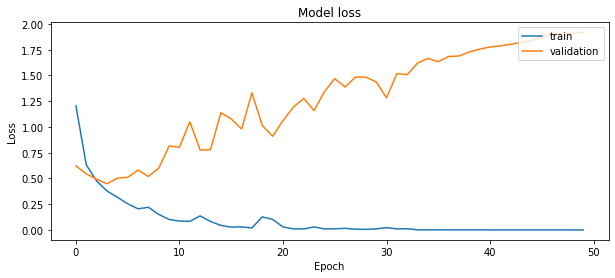

In [21]:
from keras.callbacks import ModelCheckpoint
from utils import plot_loss_function

# ubicación en donde se guardará el modelo
save_path = '//content//model_checkpoint.h5'

# inicializar ModelCheckpoint
checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy',
                             save_best_only=True)

# realizar rutina de entrenamiento
model_history = ELPV_Model.fit(X_train, Y_train,
                               batch_size=64, epochs=50 ,
                               validation_data=(X_test, Y_test),
                               callbacks=[checkpoint] )

# plot gráfico de función de pérdida
plot_loss_function(model_history, figsize=(10,4))

## Model Evaluation

Finalmente, una vez entrenado nuestro modelo debemos evaluar su desempeño. Nuevamente dada la poca cantidad de datos, utilizaremos los datos de validación como datos de testing. Para utilizar el `keras.Model` sobre nuevos datos de clasificación, conviene utilizar el método `keras.Sequential.predict`.

Por otro lado, para cargar el modelo guardado por el `ModelCheckpoint` durante el entrenamiento, se puede utilizar la función `keras.models.load_model`.

testing accuracy: 0.840


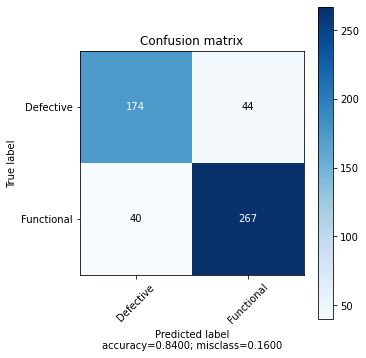

In [17]:
from keras.models import load_model

from utils import plot_confusion_matrix
from sklearn.metrics import accuracy_score

# cargar modelo (backup: workshop_03//model_backup.h5)
model_path = '//content//model_checkpoint.h5'
ELPV_Model = load_model(model_path)

# obtener predicciones de X_test
Y_pred = ELPV_Model.predict( X_test )

# para que el resultado nos sea más intuitivo transformaremos
# las etiquetas nuevamente a non one-hot-encoding
# utilizando np.argmax
labels_pred = np.argmax( Y_pred, axis=1 )
labels_true = np.argmax( Y_test, axis=1 )

# calcular accuracy de la clasificación.
accuracy = accuracy_score(labels_true, labels_pred)
print('testing accuracy: {:1.3f}'.format(accuracy))

# plot de matriz de confusión
plot_confusion_matrix(labels_true, labels_pred, ['Defective', 'Functional'])